# Data preprocessing and data visualization. Prediction model using Advanced mahine learning algorithm on any dataset

1. **Data Preprocessing** - Handling missing values, feature scaling, and data transformation
2. **Exploratory Data Analysis** - Statistical insights and visualization
3. **Advanced ML Models** - Building and comparing multiple algorithms

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading & Initial Exploration

In [2]:
# Load the diabetes dataset
df = pd.read_csv('diabetes.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("First Few Rows:")
print(df.head())
print("\n" + "="*50)
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("Statistical Summary:")
print(df.describe())

Dataset Shape: (768, 9)

First Few Rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               76

## 2. Data Preprocessing

In [3]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50)

# Handle zero values that represent missing data
# In diabetes dataset, 0 values in certain columns are missing data
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("Zero Values Count (before handling):")
for col in zero_columns:
    count = (df[col] == 0).sum()
    print(f"{col}: {count}")

# Replace zeros with NaN and then fill with median
df_clean = df.copy()
for col in zero_columns:
    df_clean[col] = df_clean[col].replace(0, np.nan)

# Fill missing values with median
df_clean[zero_columns] = df_clean[zero_columns].fillna(df_clean[zero_columns].median())

print("\n" + "="*50)
print("Zero Values Count (after handling):")
for col in zero_columns:
    count = (df_clean[col] == 0).sum()
    print(f"{col}: {count}")

Missing Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Zero Values Count (before handling):
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11

Zero Values Count (after handling):
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0


In [4]:
# Check for outliers using IQR method
print("Outlier Detection (IQR Method):")
for col in df_clean.columns:
    if col != 'Outcome':
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df_clean[col] < (Q1 - 1.5 * IQR)) | (df_clean[col] > (Q3 + 1.5 * IQR))).sum()
        print(f"{col}: {outliers} outliers")

Outlier Detection (IQR Method):
Pregnancies: 4 outliers
Glucose: 0 outliers
BloodPressure: 14 outliers
SkinThickness: 87 outliers
Insulin: 346 outliers
BMI: 8 outliers
DiabetesPedigreeFunction: 29 outliers
Age: 9 outliers


## 3. Exploratory Data Analysis (EDA) & Visualization

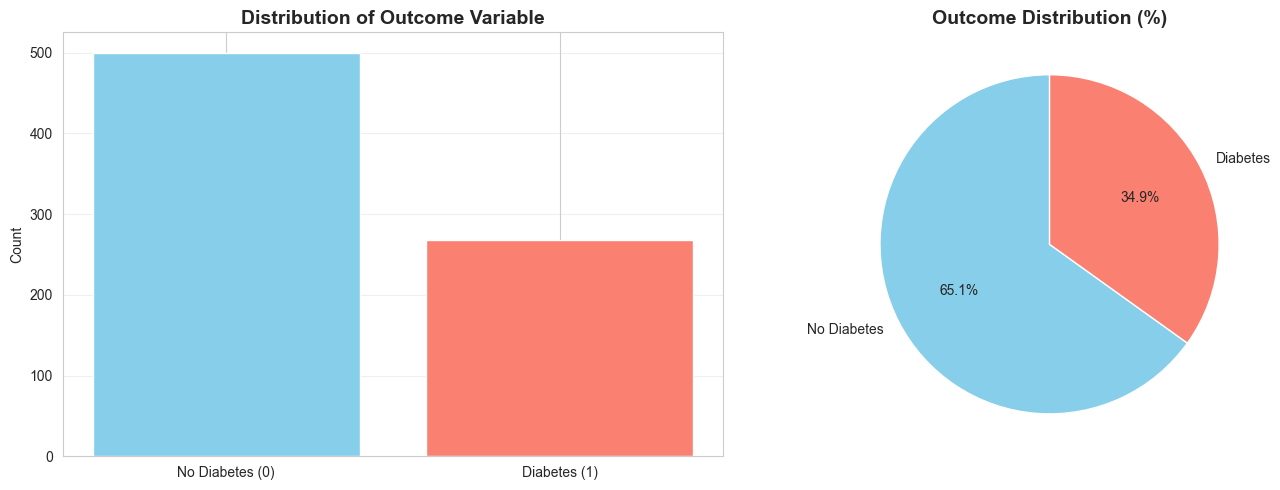

Class Distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

Class Balance Ratio: 1.87:1


In [5]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Outcome distribution
outcome_counts = df_clean['Outcome'].value_counts()
axes[0].bar(['No Diabetes (0)', 'Diabetes (1)'], outcome_counts.values, color=['skyblue', 'salmon'])
axes[0].set_title('Distribution of Outcome Variable', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Percentage distribution
axes[1].pie(outcome_counts.values, labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%', 
            colors=['skyblue', 'salmon'], startangle=90)
axes[1].set_title('Outcome Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Class Distribution:\n{outcome_counts}")
print(f"\nClass Balance Ratio: {outcome_counts[0]/outcome_counts[1]:.2f}:1")

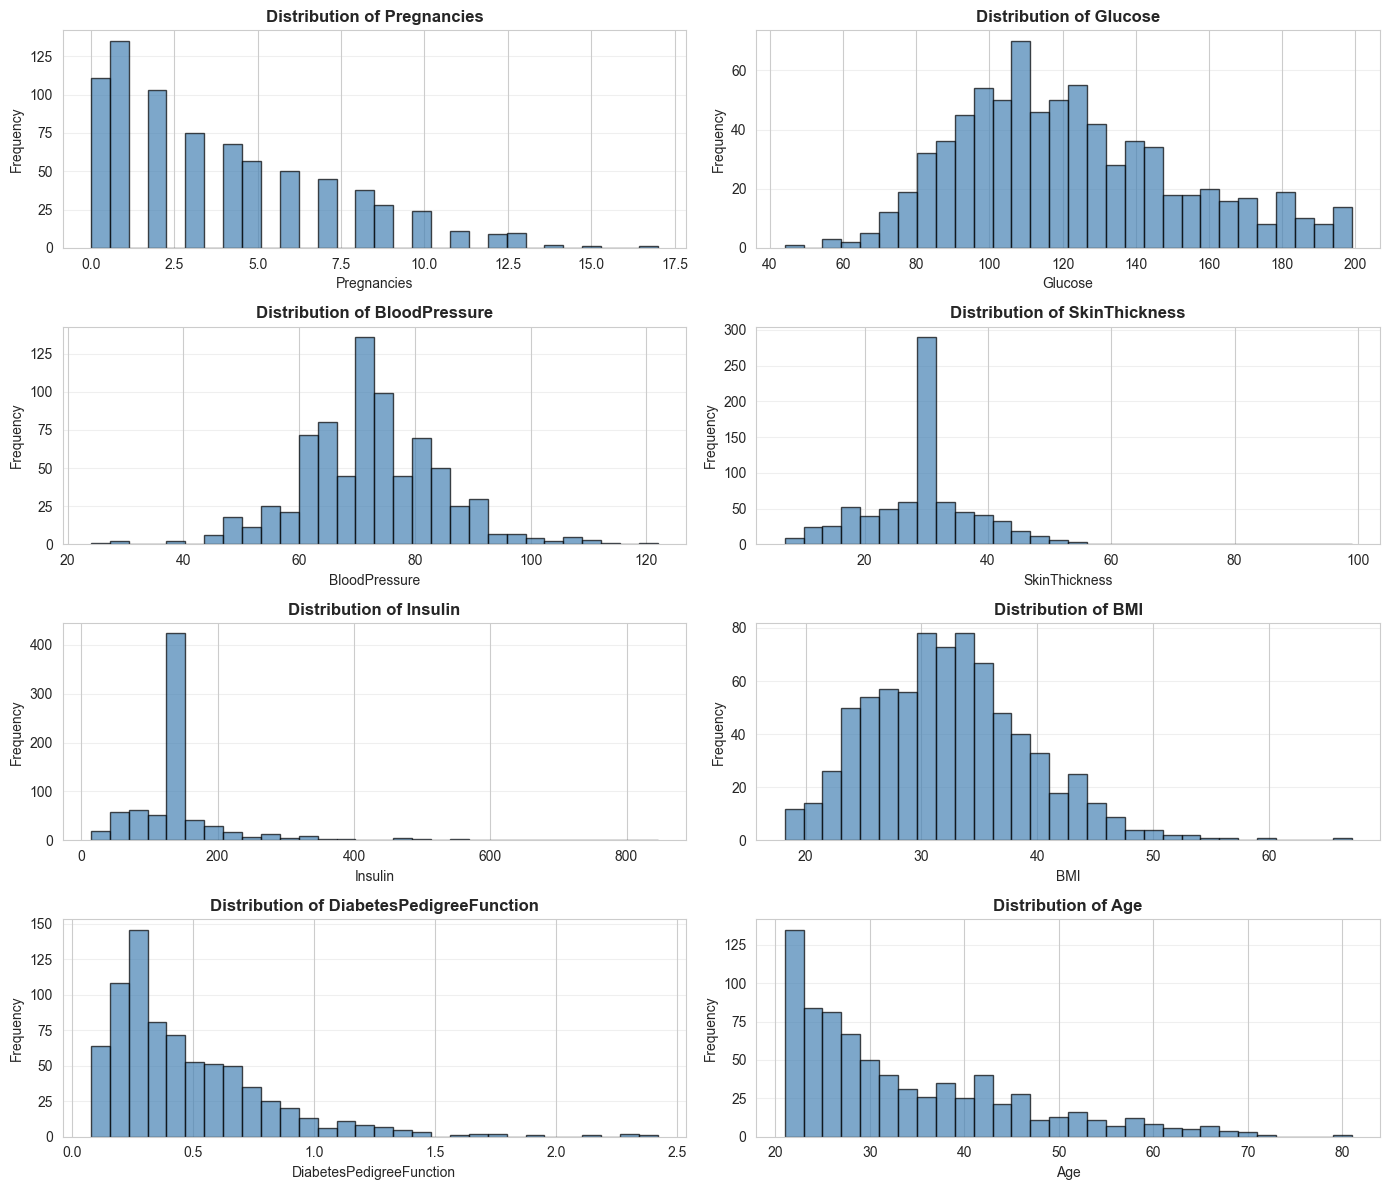

In [6]:
# Distribution of features
features = df_clean.columns[:-1]
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, feature in enumerate(features):
    axes[idx].hist(df_clean[feature], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Distribution of {feature}', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

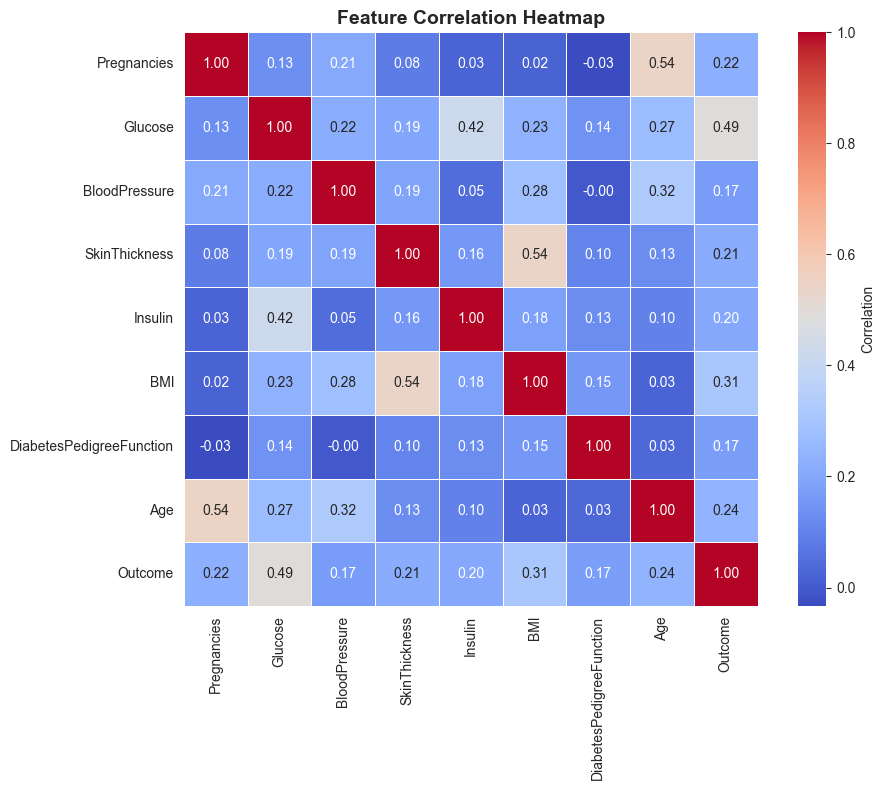


Top Features Correlated with Outcome:
Outcome                     1.000000
Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.214873
Insulin                     0.203790
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723
Name: Outcome, dtype: float64


In [7]:
# Correlation analysis
plt.figure(figsize=(10, 8))
correlation_matrix = df_clean.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, cbar_kws={'label': 'Correlation'}, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show top correlations with Outcome
print("\nTop Features Correlated with Outcome:")
outcome_corr = correlation_matrix['Outcome'].sort_values(ascending=False)
print(outcome_corr)

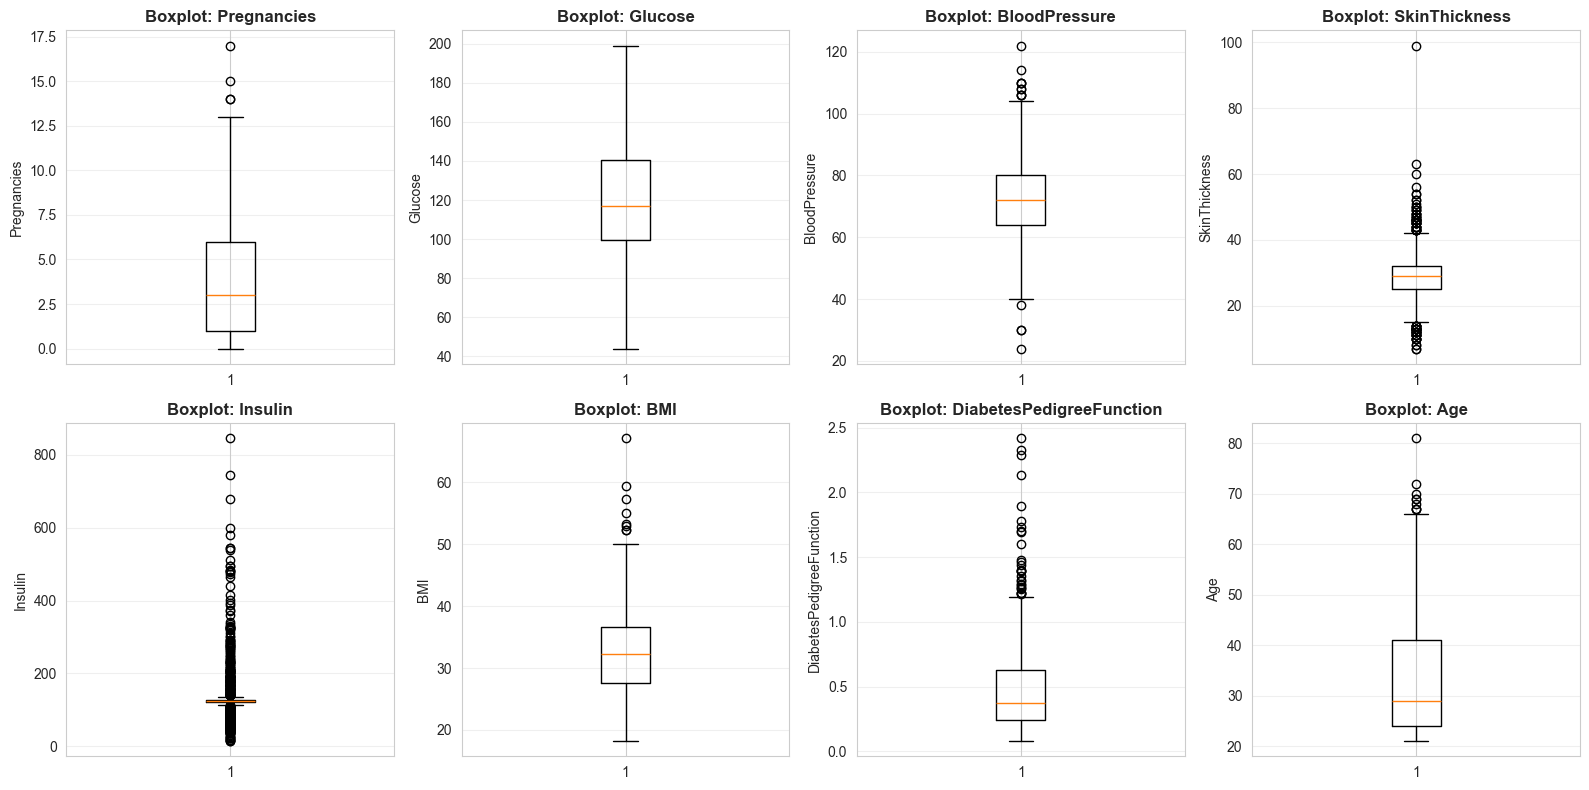

In [8]:
# Box plots for outlier visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, feature in enumerate(features):
    axes[idx].boxplot(df_clean[feature])
    axes[idx].set_title(f'Boxplot: {feature}', fontweight='bold')
    axes[idx].set_ylabel(feature)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Feature Scaling & Data Preparation

In [9]:
# Separate features and target
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining set class distribution:\n{y_train.value_counts()}")
print(f"\nTesting set class distribution:\n{y_test.value_counts()}")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*50)
print("Feature Scaling Complete!")
print("Mean of scaled training features:", X_train_scaled.mean(axis=0).round(3))
print("Std of scaled training features:", X_train_scaled.std(axis=0).round(3))

Training set size: 614
Testing set size: 154

Training set class distribution:
Outcome
0    400
1    214
Name: count, dtype: int64

Testing set class distribution:
Outcome
0    100
1     54
Name: count, dtype: int64

Feature Scaling Complete!
Mean of scaled training features: [-0. -0.  0. -0. -0. -0. -0. -0.]
Std of scaled training features: [1. 1. 1. 1. 1. 1. 1. 1.]


## 5. Advanced Machine Learning Models

In [10]:
# Dictionary to store model results
results = {}

# 1. Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=200)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
results['Logistic Regression'] = {
    'model': lr,
    'predictions': y_pred_lr,
    'probabilities': y_proba_lr
}
print("✓ Logistic Regression trained!")

# 2. Random Forest Classifier
print("Training Random Forest Classifier...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
results['Random Forest'] = {
    'model': rf,
    'predictions': y_pred_rf,
    'probabilities': y_proba_rf
}
print("✓ Random Forest trained!")

# 3. Gradient Boosting Classifier
print("Training Gradient Boosting Classifier...")
gb = GradientBoostingClassifier(n_estimators=100, random_state=42, learning_rate=0.1)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]
results['Gradient Boosting'] = {
    'model': gb,
    'predictions': y_pred_gb,
    'probabilities': y_proba_gb
}
print("✓ Gradient Boosting trained!")

# 4. AdaBoost Classifier
print("Training AdaBoost Classifier...")
ab = AdaBoostClassifier(n_estimators=100, random_state=42)
ab.fit(X_train, y_train)
y_pred_ab = ab.predict(X_test)
y_proba_ab = ab.predict_proba(X_test)[:, 1]
results['AdaBoost'] = {
    'model': ab,
    'predictions': y_pred_ab,
    'probabilities': y_proba_ab
}
print("✓ AdaBoost trained!")

# 5. Support Vector Machine (SVM)
print("Training Support Vector Machine...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]
results['SVM (RBF)'] = {
    'model': svm,
    'predictions': y_pred_svm,
    'probabilities': y_proba_svm
}
print("✓ SVM trained!")

print("\n" + "="*50)
print("All models trained successfully!")

Training Logistic Regression...
✓ Logistic Regression trained!
Training Random Forest Classifier...
✓ Random Forest trained!
Training Gradient Boosting Classifier...
✓ Gradient Boosting trained!
Training AdaBoost Classifier...
✓ AdaBoost trained!
Training Support Vector Machine...
✓ SVM trained!

All models trained successfully!


## 6. Model Evaluation & Comparison

In [11]:
# Calculate evaluation metrics for all models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

evaluation_metrics = {}

for model_name, model_data in results.items():
    y_pred = model_data['predictions']
    y_proba = model_data['probabilities']
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)
    
    evaluation_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc
    }

# Convert to DataFrame for better visualization
metrics_df = pd.DataFrame(evaluation_metrics).T
print("Model Performance Comparison:")
print("="*80)
print(metrics_df.round(4))
print("="*80)

Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-Score  AUC-ROC
Logistic Regression    0.7078     0.6000  0.5000    0.5455   0.8130
Random Forest          0.7792     0.7273  0.5926    0.6531   0.8192
Gradient Boosting      0.7597     0.6889  0.5741    0.6263   0.8317
AdaBoost               0.7597     0.6809  0.5926    0.6337   0.8169
SVM (RBF)              0.7403     0.6522  0.5556    0.6000   0.7964


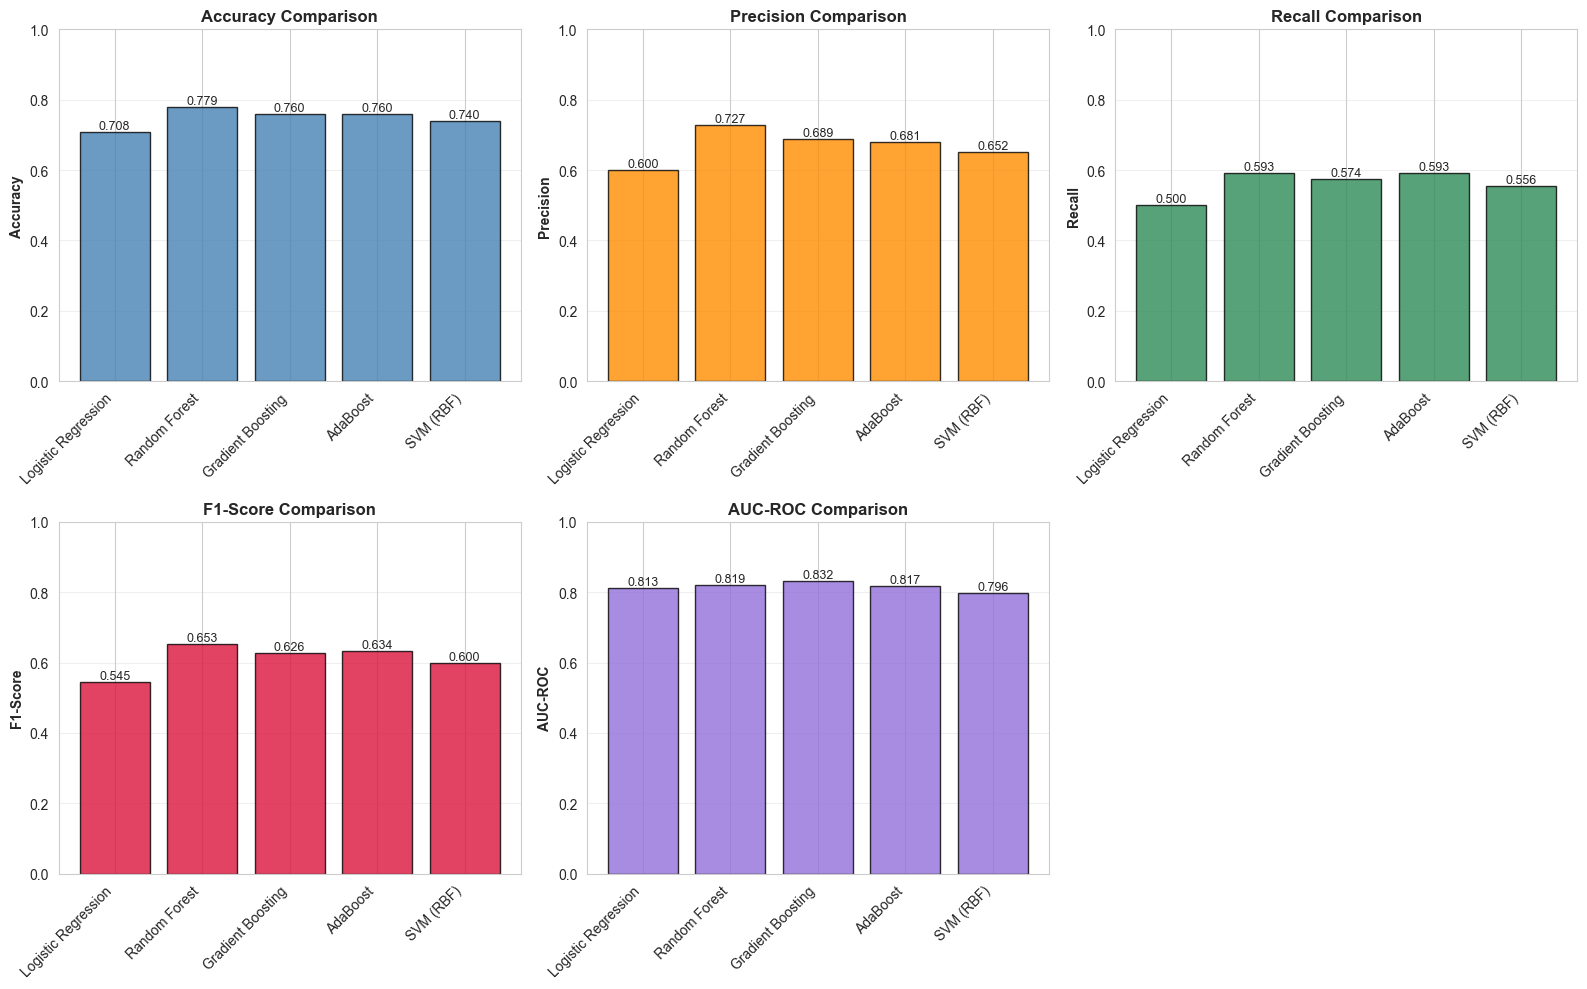

In [12]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
colors = ['steelblue', 'darkorange', 'seagreen', 'crimson', 'mediumpurple']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    values = metrics_df[metric]
    bars = ax.bar(range(len(values)), values, color=colors[idx], alpha=0.8, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values.index, rotation=45, ha='right')
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Remove extra subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()

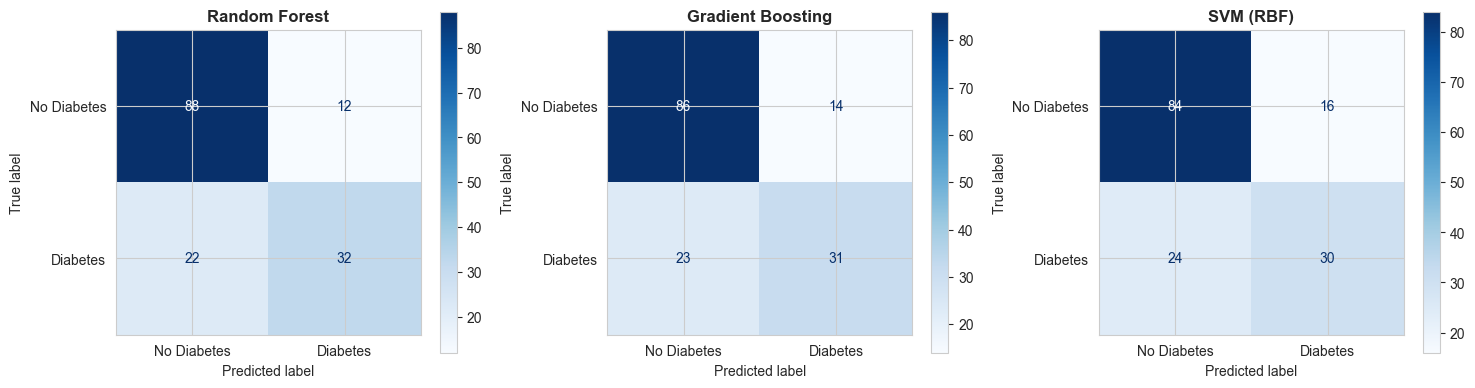

In [13]:
# Confusion Matrices for top 3 models
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

top_models = ['Random Forest', 'Gradient Boosting', 'SVM (RBF)']

for idx, model_name in enumerate(top_models):
    y_pred = results[model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_name}', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

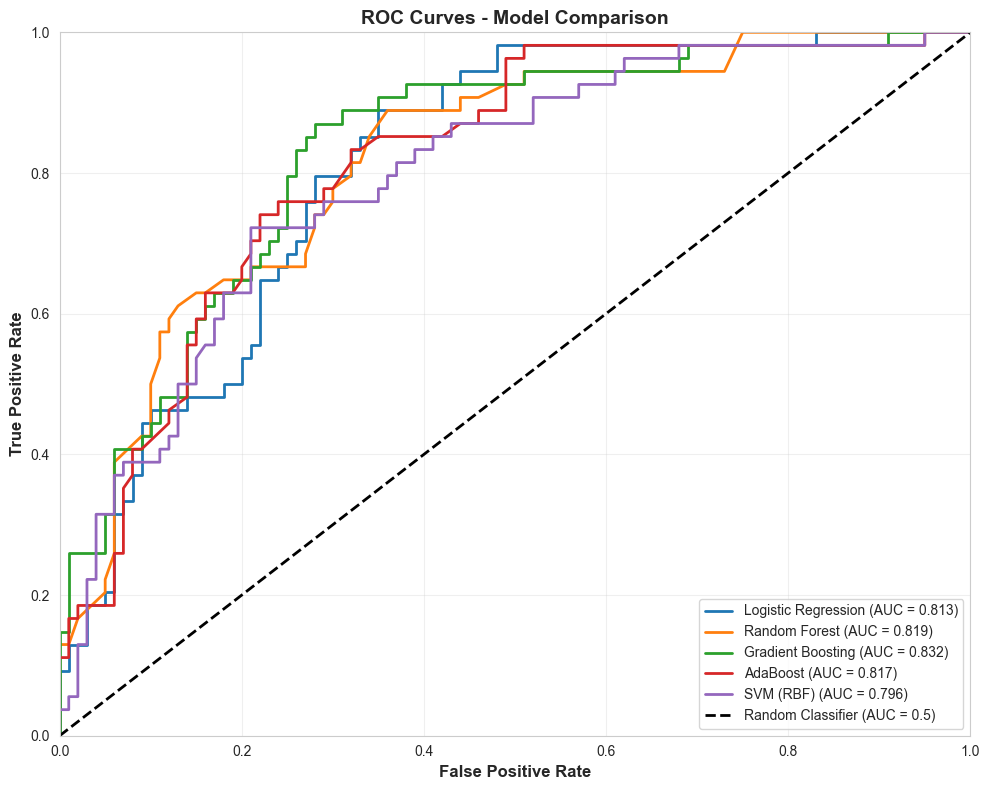

In [14]:
# ROC Curves for all models
plt.figure(figsize=(10, 8))

for model_name in results.keys():
    y_proba = results[model_name]['probabilities']
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=2)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Detailed classification reports for best performing models
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

for model_name in ['Random Forest', 'Gradient Boosting', 'SVM (RBF)']:
    print(f"\n{model_name.upper()}")
    print("-" * 80)
    y_pred = results[model_name]['predictions']
    print(classification_report(y_test, y_pred, 
                                target_names=['No Diabetes', 'Diabetes'],
                                digits=4))


DETAILED CLASSIFICATION REPORTS

RANDOM FOREST
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

 No Diabetes     0.8000    0.8800    0.8381       100
    Diabetes     0.7273    0.5926    0.6531        54

    accuracy                         0.7792       154
   macro avg     0.7636    0.7363    0.7456       154
weighted avg     0.7745    0.7792    0.7732       154


GRADIENT BOOSTING
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

 No Diabetes     0.7890    0.8600    0.8230       100
    Diabetes     0.6889    0.5741    0.6263        54

    accuracy                         0.7597       154
   macro avg     0.7389    0.7170    0.7246       154
weighted avg     0.7539    0.7597    0.7540       154


SVM (RBF)
--------------------------------------------------------------------------------
              precision  

## 7. Feature Importance Analysis

Random Forest - Feature Importance:
                    Feature  Importance
1                   Glucose    0.274086
5                       BMI    0.161903
6  DiabetesPedigreeFunction    0.125020
7                       Age    0.112985
4                   Insulin    0.091224
2             BloodPressure    0.083518
0               Pregnancies    0.080795
3             SkinThickness    0.070468


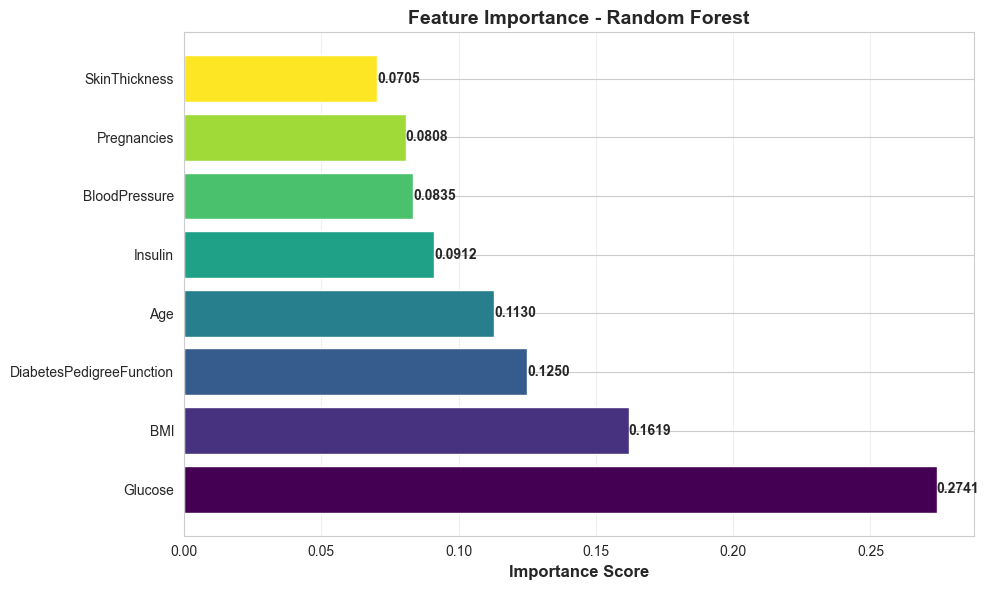

In [16]:
# Feature importance from Random Forest
rf_importance = results['Random Forest']['model'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_importance
}).sort_values('Importance', ascending=False)

print("Random Forest - Feature Importance:")
print(feature_importance_df)

# Visualization
plt.figure(figsize=(10, 6))
colors_gradient = plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df)))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors_gradient)
plt.xlabel('Importance Score', fontweight='bold', fontsize=12)
plt.title('Feature Importance - Random Forest', fontweight='bold', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Best Model Selection & Summary

In [17]:
# Find the best model based on F1-Score
best_model_name = metrics_df['F1-Score'].idxmax()
best_model = results[best_model_name]['model']
best_metrics = metrics_df.loc[best_model_name]

print("="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"\nMetrics:")
for metric, value in best_metrics.items():
    print(f"  • {metric}: {value:.4f}")

print("\n" + "="*80)
print("KEY INSIGHTS FROM ANALYSIS")
print("="*80)
print(f"""
1. DATA PREPROCESSING:
   - Missing values handled by replacing zeros with median values
   - {len(zero_columns)} features had zero values that represented missing data
   - StandardScaler applied for feature normalization

2. EXPLORATORY DATA ANALYSIS:
   - Dataset contains {len(df_clean)} diabetes records
   - Class imbalance ratio: {outcome_counts[0]/outcome_counts[1]:.2f}:1 (No Diabetes:Diabetes)
   - Most important features: {', '.join(feature_importance_df.head(3)['Feature'].tolist())}

3. MODEL PERFORMANCE:
   - {len(results)} different ML models trained and evaluated
   - Best Model: {best_model_name}
   - Accuracy: {best_metrics['Accuracy']:.4f}
   - F1-Score: {best_metrics['F1-Score']:.4f}
   - AUC-ROC: {best_metrics['AUC-ROC']:.4f}

4. RECOMMENDATIONS:
   - Use {best_model_name} for production predictions
   - Monitor Precision and Recall based on business requirements
   - Consider the class imbalance when setting decision thresholds
""")

print("="*80)

BEST MODEL SELECTION

🏆 Best Model: Random Forest

Metrics:
  • Accuracy: 0.7792
  • Precision: 0.7273
  • Recall: 0.5926
  • F1-Score: 0.6531
  • AUC-ROC: 0.8192

KEY INSIGHTS FROM ANALYSIS

1. DATA PREPROCESSING:
   - Missing values handled by replacing zeros with median values
   - 5 features had zero values that represented missing data
   - StandardScaler applied for feature normalization

2. EXPLORATORY DATA ANALYSIS:
   - Dataset contains 768 diabetes records
   - Class imbalance ratio: 1.87:1 (No Diabetes:Diabetes)
   - Most important features: Glucose, BMI, DiabetesPedigreeFunction

3. MODEL PERFORMANCE:
   - 5 different ML models trained and evaluated
   - Best Model: Random Forest
   - Accuracy: 0.7792
   - F1-Score: 0.6531
   - AUC-ROC: 0.8192

4. RECOMMENDATIONS:
   - Use Random Forest for production predictions
   - Monitor Precision and Recall based on business requirements
   - Consider the class imbalance when setting decision thresholds

